You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
df=pd.read_csv('results.csv')

In [3]:
pd.set_option('display.expand_frame_repr', False)
from IPython.display import display
pd.options.display.max_columns=None
df=df.reindex(sorted(df.columns),axis=1)
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,47,W1,Fukuoka,JPN,NaN,8,M,8,39.72,"Yamamoto, Hiroyuki",85.25,8,3.27,NaN
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,33,F1,Eldoret,KEN,NaN,1,F,1,69.47,"Jeptoo, Rita",138.95,21,5.30,NaN
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,41,W2,Paarl,RSA,NaN,1,M,1,38.03,"Van Dyk, Ernst F.",80.60,1,3.08,NaN
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,24,F2,Shoa,ETH,NaN,3,F,3,69.47,"Dibaba, Mare",140.58,27,5.37,NaN
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,40,W3,Nogata Fukuoka,JPN,NaN,2,M,2,38.60,"Hokinoue, Kota",81.23,2,3.10,NaN


In [4]:
df.dtypes

10k           object
20k           object
25k           object
30k           object
35k           object
40k           object
5k            object
age            int64
bib           object
city          object
country       object
ctz           object
division       int64
gender        object
genderdiv      int64
half          object
name          object
official     float64
overall        int64
pace         float64
state         object
dtype: object

In [5]:
X=df.iloc[:,:7]

In [6]:
df.shape

(31984, 21)

## Features Selection

In [7]:
col=X.columns.values
col

array(['10k', '20k', '25k', '30k', '35k', '40k', '5k'], dtype=object)

## Data Cleaning

In [8]:
col=X.columns.values
for i in col:
    df.drop(df[df[i]=='-'].index,inplace=True)
    df[i]=df[i].astype(float)

In [9]:
df.shape

(31687, 21)

In [10]:
df.dtypes

10k          float64
20k          float64
25k          float64
30k          float64
35k          float64
40k          float64
5k           float64
age            int64
bib           object
city          object
country       object
ctz           object
division       int64
gender        object
genderdiv      int64
half          object
name          object
official     float64
overall        int64
pace         float64
state         object
dtype: object

In [11]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,47,W1,Fukuoka,JPN,NaN,8,M,8,39.72,"Yamamoto, Hiroyuki",85.25,8,3.27,NaN
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,33,F1,Eldoret,KEN,NaN,1,F,1,69.47,"Jeptoo, Rita",138.95,21,5.30,NaN
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,41,W2,Paarl,RSA,NaN,1,M,1,38.03,"Van Dyk, Ernst F.",80.60,1,3.08,NaN
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,24,F2,Shoa,ETH,NaN,3,F,3,69.47,"Dibaba, Mare",140.58,27,5.37,NaN
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,40,W3,Nogata Fukuoka,JPN,NaN,2,M,2,38.60,"Hokinoue, Kota",81.23,2,3.10,NaN


## Shuffle

In [12]:
from sklearn.utils import shuffle
df = shuffle(df)

In [13]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
14880,55.57,114.90,146.73,179.52,215.87,250.50,27.30,27,17021,Brookfield,USA,NaN,4724,F,9513,121.43,"Schmidt, Kelly M.",265.53,22731,10.13,WI
16990,56.58,114.47,143.25,171.47,200.18,228.63,28.38,40,19437,Harrisburg,USA,NaN,1451,F,8191,120.70,"Casey, Shelley",251.25,20293,9.58,PA
4060,43.98,89.07,112.73,139.18,165.80,193.22,22.05,33,4604,Grandview Heights,USA,NaN,3140,M,6276,94.23,"Gallogly, Joshua A",204.47,7638,7.80,OH
1946,41.50,84.80,107.52,131.42,156.02,181.60,20.87,41,2211,Kokomo,USA,NaN,889,M,4538,89.60,"High, Christian J.",194.18,5080,7.42,IN
31527,60.22,127.95,163.43,201.00,241.37,278.47,28.63,54,35421,Tokyo,JPN,NaN,2158,M,15012,135.40,"Ogasawara, Hitoshi",293.70,26549,11.22,NaN


## Reset dataframe Index

In [14]:
df=df.reset_index(drop=True)

In [15]:
df.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
0,55.57,114.90,146.73,179.52,215.87,250.50,27.30,27,17021,Brookfield,USA,NaN,4724,F,9513,121.43,"Schmidt, Kelly M.",265.53,22731,10.13,WI
1,56.58,114.47,143.25,171.47,200.18,228.63,28.38,40,19437,Harrisburg,USA,NaN,1451,F,8191,120.70,"Casey, Shelley",251.25,20293,9.58,PA
2,43.98,89.07,112.73,139.18,165.80,193.22,22.05,33,4604,Grandview Heights,USA,NaN,3140,M,6276,94.23,"Gallogly, Joshua A",204.47,7638,7.80,OH
3,41.50,84.80,107.52,131.42,156.02,181.60,20.87,41,2211,Kokomo,USA,NaN,889,M,4538,89.60,"High, Christian J.",194.18,5080,7.42,IN
4,60.22,127.95,163.43,201.00,241.37,278.47,28.63,54,35421,Tokyo,JPN,NaN,2158,M,15012,135.40,"Ogasawara, Hitoshi",293.70,26549,11.22,NaN


## Deivide dataset to 4 evenly sized subset

In [16]:
rows=df.shape[0]-df.shape[0]%4
df=df.iloc[:rows,:8]
df.head()

,10k,20k,25k,30k,35k,40k,5k,age
0,55.57,114.90,146.73,179.52,215.87,250.50,27.30,27
1,56.58,114.47,143.25,171.47,200.18,228.63,28.38,40
2,43.98,89.07,112.73,139.18,165.80,193.22,22.05,33
3,41.50,84.80,107.52,131.42,156.02,181.60,20.87,41
4,60.22,127.95,163.43,201.00,241.37,278.47,28.63,54


In [17]:
df.shape

(31684, 8)

In [18]:
df=np.split(df,4,axis=0)

In [19]:
df[0]

,10k,20k,25k,30k,35k,40k,5k,age
0,55.57,114.90,146.73,179.52,215.87,250.50,27.30,27
1,56.58,114.47,143.25,171.47,200.18,228.63,28.38,40
2,43.98,89.07,112.73,139.18,165.80,193.22,22.05,33
3,41.50,84.80,107.52,131.42,156.02,181.60,20.87,41
4,60.22,127.95,163.43,201.00,241.37,278.47,28.63,54
5,67.08,139.42,174.53,215.77,262.47,301.70,32.87,31
6,43.13,87.13,108.97,131.63,154.95,178.13,21.60,21
7,43.75,88.60,111.20,134.17,158.48,182.73,21.80,48
8,50.15,104.22,129.73,156.77,184.00,208.60,24.83,38
9,45.13,90.68,113.75,138.17,164.17,191.08,22.53,33


## Features Selection

In [20]:
df[0].iloc[:rows,:7]

,10k,20k,25k,30k,35k,40k,5k
0,55.57,114.90,146.73,179.52,215.87,250.50,27.30
1,56.58,114.47,143.25,171.47,200.18,228.63,28.38
2,43.98,89.07,112.73,139.18,165.80,193.22,22.05
3,41.50,84.80,107.52,131.42,156.02,181.60,20.87
4,60.22,127.95,163.43,201.00,241.37,278.47,28.63
5,67.08,139.42,174.53,215.77,262.47,301.70,32.87
6,43.13,87.13,108.97,131.63,154.95,178.13,21.60
7,43.75,88.60,111.20,134.17,158.48,182.73,21.80
8,50.15,104.22,129.73,156.77,184.00,208.60,24.83
9,45.13,90.68,113.75,138.17,164.17,191.08,22.53


## Create Empty List

In [21]:
features=[]
target=[]

In [22]:
for i in range(0,4):
    features.append(df[i].iloc[:rows,:7])
    target.append(df[i].iloc[:rows,7])

In [23]:
X_norm=normalize(features[0])
X_pca=PCA(2).fit_transform(X_norm)
y=np.where(target[0]>42,1,0)


In [24]:
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

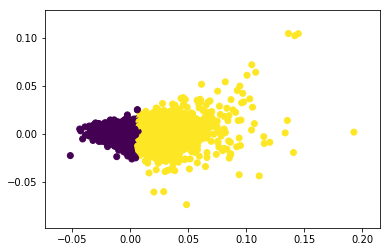

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [26]:
pd.crosstab(y_pred,y)

col_0,0,1
row_0,,
0,2794,2725
1,1097,1305


In [27]:
from sklearn import metrics
metrics.adjusted_rand_score(y,y_pred)

0.0010687260529438495